In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np

In [2]:
from train import Dataset

In [3]:
train_dataset = Dataset('../data', window_len=10, pull_len=50, normalize_max=100)

In [4]:
len(train_dataset.samples)

137

In [5]:
num_neg = 0
num_pos = 0

for sample in train_dataset.samples:
    if sample[1] == 0:
        num_neg += 1
    else:
        num_pos += 1

print(num_neg, num_pos)

34 103


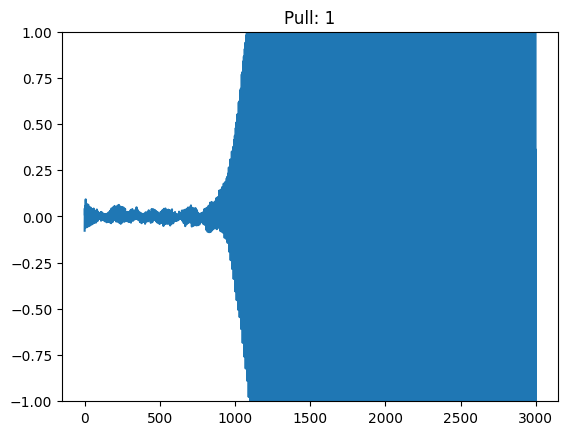

In [6]:
def viz_seq(i):
    x, y = train_dataset[i]
    # x = x.reshape(-1, 15)

    plt.close()
    plt.figure()
    plt.plot(x)
    plt.title('Pull: {}'.format(y))
    plt.ylim(-1, 1)
    plt.show()

viz_seq(35)

In [7]:
# total_force = [x.sum().abs() for x, y in train_dataset.samples]

# xy_mask = [0, 1, 3, 4, 6, 7, 9, 10, 12, 13]

xy_total_force = np.array([np.abs((x).sum()) for x, y in train_dataset.samples])
total_deviation = np.array([x.std(axis=0).sum() for x, y in train_dataset.samples])
total_diff = np.array([x.max() - x.min() for x, y in train_dataset.samples])


features = np.concatenate((total_diff.reshape(-1, 1), xy_total_force.reshape(-1, 1), total_deviation.reshape(-1, 1)), axis=1)
labels = np.array([y for x, y in train_dataset.samples])

In [8]:
# solve logistics regression for features and labels
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

clf = LogisticRegression(random_state=0, solver='lbfgs').fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00        22

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28



In [9]:
clf.coef_

array([[0.26676689, 0.00349596, 2.08305106]])

In [10]:
import pickle

with open("../checkpoints/handover/eflesh_linear.pkl", "wb") as f:
    pickle.dump(clf, f)

In [11]:
correct = 0
total_diff_threshold = 0.25
for i in range(len(labels)):
    correct += (total_diff[i] > total_diff_threshold) == labels[i]

print(correct / len(labels))

0.7518248175182481


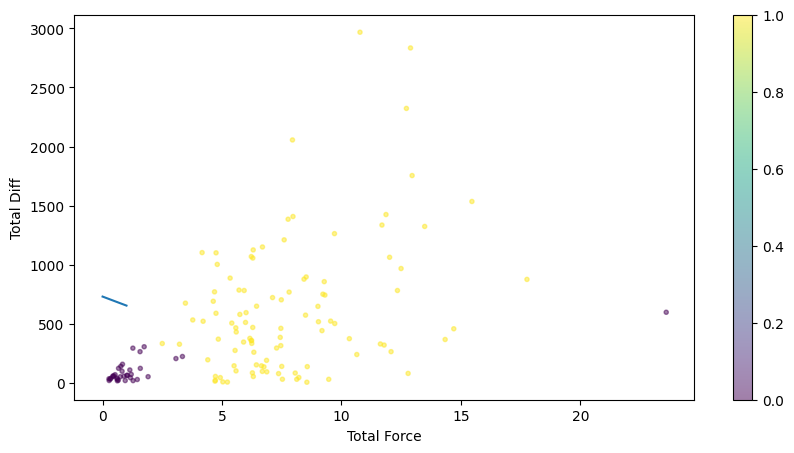

In [12]:
# plot the total force with the labels as a scatter plot
plt.figure(figsize=(10, 5))
plt.scatter(total_diff, xy_total_force, c=labels, cmap='viridis', marker='.', alpha=0.5)

# plot the decision boundary
x = np.linspace(0, 1, 100)
y = (-clf.coef_[0][0] * x - clf.intercept_) / clf.coef_[0][1]

plt.plot(x, y, label='Decision Boundary')

plt.xlabel('Total Force')
plt.ylabel('Total Diff')
plt.colorbar()
plt.show()
